In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [2]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.4
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [3]:
torch.cuda.is_available()

False

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


#### 모델 저장

In [5]:
def saveModel():
    torch.save(model.state_dict(), 'model_lstm_autoencoder_ARMA(1_1).pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [6]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 200       # 생성할 학습 데이터 시퀀스의 수 
validrun = 100         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi, theta별로 생성)
phi = np.array([0.2, 0.2, 0.4, 0.8, 0.8])
theta = np.array([-0.2, -0.8, -0.4, -0.2, -0.8])

# 변화율 크기
psi1 = 0

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [7]:
np.random.seed(1)

# ARMA(1,1) 시계열 데이터 생성 함수
def arma1_1(phi, theta, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                                                        # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt((1 + 2 * phi * theta + theta**2)/ (1 - phi**2))     # ARMA(1,1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.array(np.repeat(0, length), dtype=np.float64)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = phi * x[i - 1] - theta * e[i-1] + e[i]     # ARMA(1,1)모델의 관리상태
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # ARMA(1,1)모델의 이상상태
            e[i] = gamma * e[i]
            x[i] = phi * x[i - 1] - theta * e[i-1] + e[i] 
        
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.empty(shape=(len(phi), run, length))
    
    # 매개변수 조합별 데이터 생성
    for i, (phi_, theta_) in enumerate(zip(phi, theta)):
        y[i]= arma1_1(phi_, theta_, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi), length)                 # 생성된 데이터를 적절한 형태로 재배열



In [8]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)    

In [9]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [10]:
len(trainloader)

1000

In [11]:
len(validloader)

500

In [12]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1])

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(0)
        repeated_z = z.repeat(self.seq_length, 1, 1).transpose(0, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=length, seq_length=length, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)  # You can adjust the initial lr based on your model and training needs
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 2.8348, Validation Loss: 2.9523
Validation loss decreased (inf --> 2.952266).  Saving model ...
Epoch 2, Train Loss: 2.8341, Validation Loss: 2.9521
Validation loss decreased (2.952266 --> 2.952068).  Saving model ...
Epoch 3, Train Loss: 2.8335, Validation Loss: 2.9519
Validation loss decreased (2.952068 --> 2.951875).  Saving model ...
Epoch 4, Train Loss: 2.8328, Validation Loss: 2.9517
Validation loss decreased (2.951875 --> 2.951714).  Saving model ...
Epoch 5, Train Loss: 2.8323, Validation Loss: 2.9515
Validation loss decreased (2.951714 --> 2.951545).  Saving model ...
Epoch 6, Train Loss: 2.8316, Validation Loss: 2.9514
Validation loss decreased (2.951545 --> 2.951364).  Saving model ...
Epoch 7, Train Loss: 2.8311, Validation Loss: 2.9512
Validation loss decreased (2.951364 --> 2.951166).  Saving model ...
Epoch 8, Train Loss: 2.8305, Validation Loss: 2.9509
Validation loss decreased (2.951166 --> 2.950941).  Saving model ...
Epoch 9, Train Loss: 2.8298, 

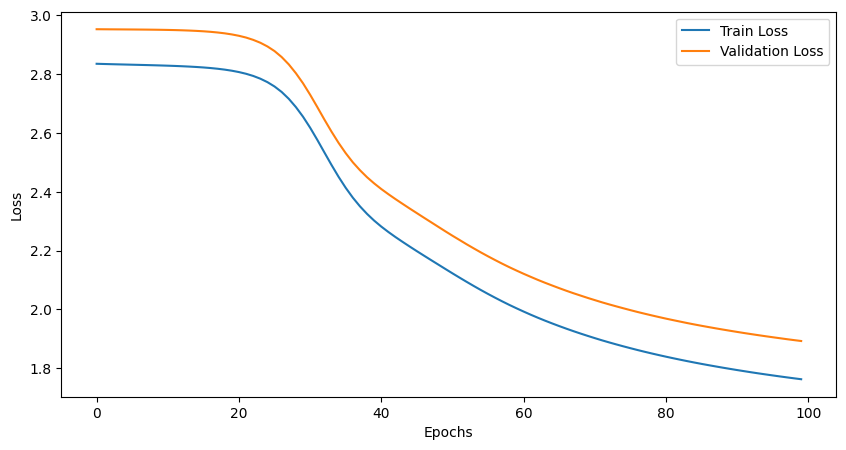

In [21]:
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data                                                           # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
 
    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs=400)  # Set the appropriate number of epochs

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 모델 불러오기

In [15]:
model.load_state_dict(torch.load('model_lstm_autoencoder_ARMA(1_1).pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### ARL0 함수

In [16]:
np.random.seed(1)

l = 12 # 윈도우 사이즈

# ARMA(1,1) 시계열 관리상태 데이터 생성 함수
def arma1_1_gen(phi, theta, psi, delta, gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt((1 + 2 * phi * theta + theta**2)/ (1 - phi**2))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = phi * x[i - 1] - theta * e[i-1] + e[i]
        z[i] = x[i]
        
    for i in range(psi,len(x)):
        x[i] = phi * x[i - 1] - theta * e[i-1] + gamma * e[i]
        z[i] = x[i]
        
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [17]:
def arl(phi, theta, delta, gamma, run, length, cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = arma1_1_gen(phi, theta, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l)) 
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)
                
                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0])

                if loss > cl :
                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)
            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl


#### ARL1 함수

In [18]:
def arl1(phi, theta, run, length, cl):
    a5 = arl(phi, theta, 0.5, 1, run, length, cl)
    a1 = arl(phi, theta, 1, 1, run, length, cl)
    a2 = arl(phi, theta, 2, 1, run, length, cl)
    a3 = arl(phi, theta, 3, 1, run, length, cl)
    b5 = arl(phi, theta, 0.5, 1.5,run, length, cl)
    b1 = arl(phi, theta, 1, 1.5, run, length, cl)
    b2 = arl(phi, theta, 2, 1.5, run, length, cl)
    b3 = arl(phi, theta, 3, 1, run, length, cl)
    c1 = arl(phi, theta, 0, 1.5, run, length, cl)
    c2 = arl(phi, theta, 0, 2, run, length, cl)
    c3 = arl(phi, theta, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### phi = 0.2, theta = -0.2 일 때

##### ARL0 (threshold 임의추정)

In [20]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.428)

100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


328.722

In [21]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.45)

100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


336.4

In [22]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.5)

100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


386.037

In [23]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.48)

100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


352.705

In [25]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.485)

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


367.328

In [26]:
arl(phi=0.2, theta=-0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.485)

100%|██████████| 10000/10000 [30:46<00:00,  5.42it/s]


368.6991

##### ARL1

In [29]:
arl1(phi=0.2, theta=-0.2, run=10000, length=1000, cl=2.485)

100%|██████████| 10000/10000 [00:28<00:00, 355.25it/s]

0.5: 300.9085, 1:169.0882,2:38.278,3:7.188
0.5:19.6525,1:16.3231,2:9.1638,3:7.1979
1.5:20.9646,2:8.6231,3:4.1799


#### phi = 0.2, theta = -0.8 일 때

##### ARL0 (threshold 임의추정)

In [30]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.54)

100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


323.378

In [31]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.56)

100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


344.852

In [32]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.59)

100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s]


345.213

In [34]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.63)

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


374.457

In [35]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 4.63)

100%|██████████| 10000/10000 [30:03<00:00,  5.54it/s]


365.4233

In [37]:
arl(phi=0.2, theta=-0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 4.65)

100%|██████████| 10000/10000 [30:35<00:00,  5.45it/s]


371.8598

##### ARL1

In [38]:
arl1(phi=0.2, theta=-0.8, run=10000, length=1000, cl=4.65)

100%|██████████| 10000/10000 [00:42<00:00, 236.46it/s]

0.5: 319.7576, 1:221.434,2:66.135,3:16.4081
0.5:42.9628,1:35.6739,2:19.6347,3:17.0093
1.5:46.8985,2:17.0793,3:6.872


#### phi = 0.4, theta = -0.4 일 때

##### ARL0 (threshold 임의추정)

In [39]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.9)

100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


340.317

In [41]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.1)

100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]


419.884

In [42]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4)

100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


389.046

In [44]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.95)

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


360.696

In [50]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.98)

100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


370.689

In [49]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.99)

100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


386.194

In [51]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 3.98)

100%|██████████| 10000/10000 [2:06:27<00:00,  1.32it/s]   


363.1583

In [53]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 3.985)

100%|██████████| 10000/10000 [30:06<00:00,  5.54it/s]


366.5101

In [54]:
arl(phi=0.4, theta=-0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 3.988)

100%|██████████| 10000/10000 [30:01<00:00,  5.55it/s]


368.2293

##### ARL1

In [55]:
arl1(phi=0.4, theta=-0.4, run=10000, length=1000, cl=3.988)

100%|██████████| 10000/10000 [00:37<00:00, 266.03it/s]

0.5: 334.5116, 1:241.2498,2:87.2137,3:25.7061
0.5:33.7882,1:29.4253,2:19.102,3:25.8751
1.5:36.1992,2:13.8843,3:5.9537


#### Case 4) phi = 0.8, theta = -0.2 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 7.3
arl(phi=0.8, theta=-0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 7.3)

100%|██████████| 10000/10000 [01:33<00:00, 106.85it/s]


16.1635

##### ARL1

In [ ]:
arl1(phi=0.8, theta=-0.2, run=1000, length=1000, cl=7.3)

#### Case 5) phi = 0.8, theta = -0.8 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 15.13
arl(phi=0.8, theta=-0.8, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 15.13)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 11%|█         | 1112/10000 [03:01<24:07,  6.14it/s]


##### ARL1

In [ ]:
arl1(phi=0.8, theta=-0.8, run=1000, length=1000, cl=15.13)